<h1 style="font-size:30px;">Transfer Learning using VGG-16 (as a Feature Extractor)</h1>  

In this notebook, I will train an Image Classifier using a pretrained model. I will use the VGG-16 network architecture but instantiate the convolutional base of the network with weights that have been pre-trained on the ImageNet dataset. I will add my own classification layer and only train that portion of the network on the **ecommerce images** dataset to demonstrate that using a pre-trained convolutional base can be an effective approach for adapting a network to a new problem type.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (
    MultipleLocator, FormatStrFormatter
)
from dataclasses import dataclass

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42

## 1 System Configuration

In [2]:
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Download and Extract the Dataset

## 3 Dataset and Training Configuration

In [66]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 9
    IMG_HEIGHT:   int = 628
    IMG_WIDTH:    int = 442
#    IMG_HEIGHT:  int = 224
#    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 32
    DATA_ROOT_TRAIN:   str = 'D:\\tmp\\Andrea\\train\\train'
    DATA_ROOT_VALID:   str = 'D:\\tmp\\Andrea\\test'

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 51
    LEARNING_RATE:  float = 0.0001
    CHECKPOINT_DIR: str   = '/.keras'

## 4 Modeling VGG-16

The Keras API provides the following utility that is used to instantiate a VGG-16 model which can be initialized with either pre-trained weights from ImageNet or random initial weights. **In this notebook, we will load the model with weights from the ImageNet dataset.** For more information on the VGG-16 model available in Keras, refer to the: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>
```python
tf.keras.applications.vgg16.VGG16(include_top=True,
                                  weights='imagenet',
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```
### 4.1 VGG Convolutional Base

We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False` which excludes the fully connected layers. **In the previous notebook, we initialized the convolutional base with random weights so we could train the model from scratch, however, here, we will instantiate the model with weights from the ImageNet dataset.**

In [67]:
#input_shape = (DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT, DatasetConfig.CHANNELS)
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
# Set the `trainable` attribute of the convolutional base to `False` so that the weights are not changed.
vgg16_conv_base.trainable = False
print('All weights trainable, fine tuning...')

Loading model with ImageNet weights...
All weights trainable, fine tuning...


In [68]:
print(vgg16_conv_base.summary())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 628, 442, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 628, 442, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 628, 442, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 314, 221, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 314, 221, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 314, 221, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 157, 110, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 157, 110, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 157, 110, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 157, 110, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 78, 55, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 78, 55, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 78, 55, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 78, 55, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 39, 27, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 39, 27, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 39, 27, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 39, 27, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 19, 13, 512)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### 4.2 Add the Classification Layer
Since we intend to train and use the model to classify the ecommerce imgaes (which has only 9 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 256 nodes, followed by a softmax output layer that contains 9 nodes for each of the 9 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset. This is the same approach we used in the previous notebook.

In [69]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = vgg16_conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

# The final `Dense` layer with the number of classes.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)

# The final model.
vgg16_model = keras.Model(inputs, outputs)

print(vgg16_model.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)   │ (None, 628, 442, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_18 (GetItem)         │ (None, 628, 442)          │               0 │ input_layer_14[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_19 (GetItem)         │ (None, 628, 442)          │               0 │ input_layer_14[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_20 (GetItem)         │ (None, 628, 442)          │               0 │ input_layer_14[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stack_6 (Stack)               │ (None, 628, 442, 3)       │               0 │ get_item_18[0][0],         │
│                               │                           │                 │ get_item_19[0][0],         │
│                               │                           │                 │ get_item_20[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_6 (Add)                   │ (None, 628, 442, 3)       │               0 │ stack_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 19, 13, 512)       │      14,714,688 │ add_6[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_6 (Flatten)           │ (None, 126464)            │               0 │ vgg16[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 256)               │      32,375,040 │ flatten_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 9)                 │           2,313 │ dense_12[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 47,092,041 (179.64 MB)

 Trainable params: 32,377,353 (123.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### 4.3 Prepare the Training and Validation Dataset

In [70]:
input_shape

(628, 442, 3)

In [71]:
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH)

train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
#                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             image_size=input_shape,
                                             )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
#                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             image_size=input_shape,
                                             )


Found 431 files belonging to 9 classes.
Found 151 files belonging to 9 classes.


### 4.4 Display Sample Images

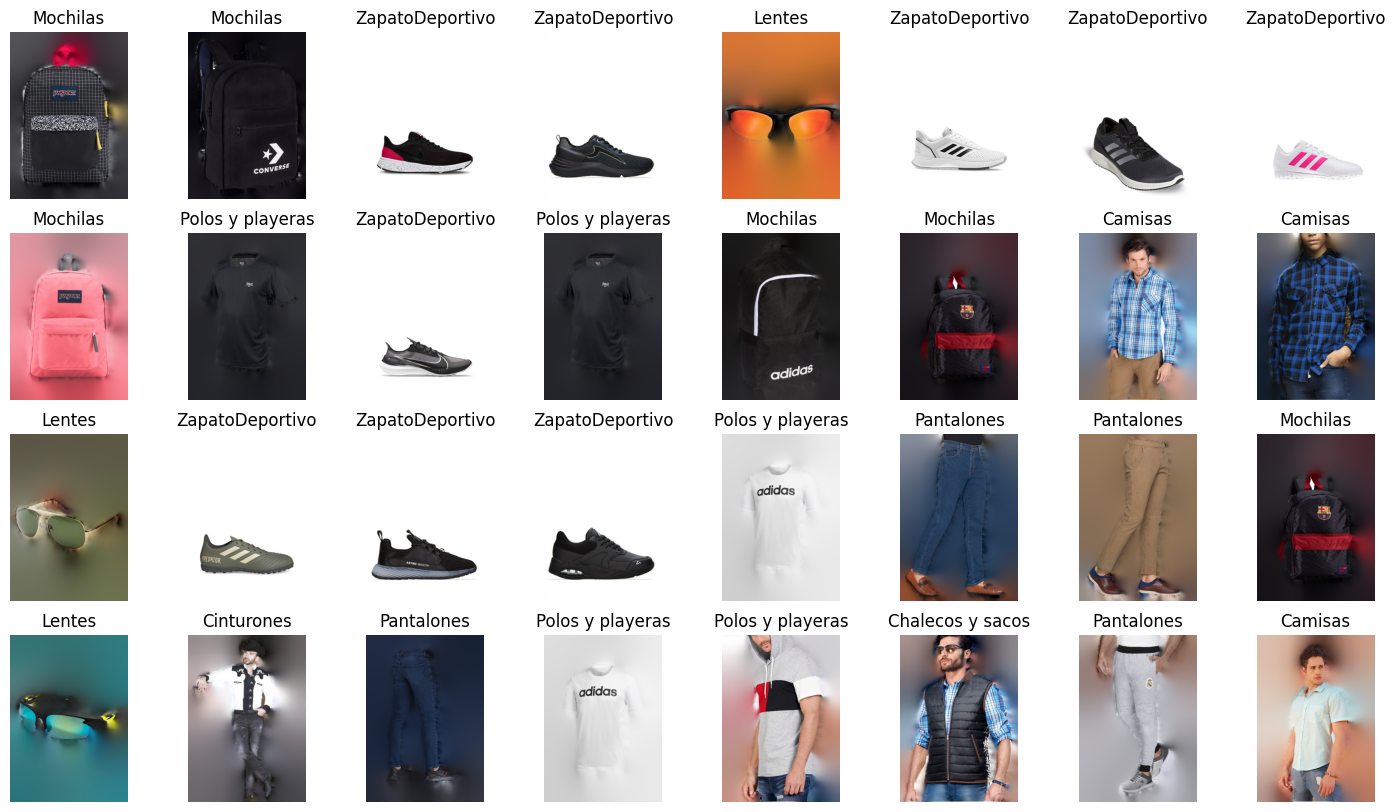

In [72]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):

    # For the batch of images and the associated (one-hot encoded) labels,
    # plot each of the images in the batch and the associated ground truth labels.
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.imshow(image_batch[idx].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[idx].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 4.5 Compile and Evaluate the Base Model Prior Final Training
At this point we can compile and evaluate the model before training the dense classifier.

In [73]:
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [74]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

Checking model accuracy before transfer learning.

In [75]:
print(f"Model evaluation accuracy: {vgg16_model.evaluate(valid_dataset)[1]*100.:.3f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 19s/step - accuracy: 0.1912 - loss: 8.3628
Model evaluation accuracy: 19.205


### 4.6 Train the Model

In [77]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [79]:
# Train the Model.
training_results = vgg16_model.fit(train_dataset,
                                   validation_data=valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
#                                   callbacks=model_checkpoint_callback,
                                   callbacks=[early_stopping])


Epoch 1/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 446s 33s/step - accuracy: 1.0000 - loss: 3.3605e-06 - val_accuracy: 0.9139 - val_loss: 1.7872
Epoch 2/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 442s 32s/step - accuracy: 1.0000 - loss: 1.1186e-06 - val_accuracy: 0.9139 - val_loss: 1.7861
Epoch 3/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 479s 35s/step - accuracy: 1.0000 - loss: 1.0881e-06 - val_accuracy: 0.9139 - val_loss: 1.7850
Epoch 4/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 473s 34s/step - accuracy: 1.0000 - loss: 9.9017e-07 - val_accuracy: 0.9139 - val_loss: 1.7839
Epoch 5/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 468s 34s/step - accuracy: 1.0000 - loss: 7.9504e-07 - val_accuracy: 0.9139 - val_loss: 1.7828
Epoch 6/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 461s 33s/step - accuracy: 1.0000 - loss: 1.2414e-06 - val_accuracy: 0.9139 - val_loss: 1.7817
Epoch 7/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 452s 33s/step - accuracy: 1.0000 - loss: 1.9000e-06 - val_accuracy: 0.9139 - val_loss: 1.7808
Epoch 8/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 438s 32s/step - accuracy: 1.0000 - los

### 4.7 Plot the Training Results

In [80]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

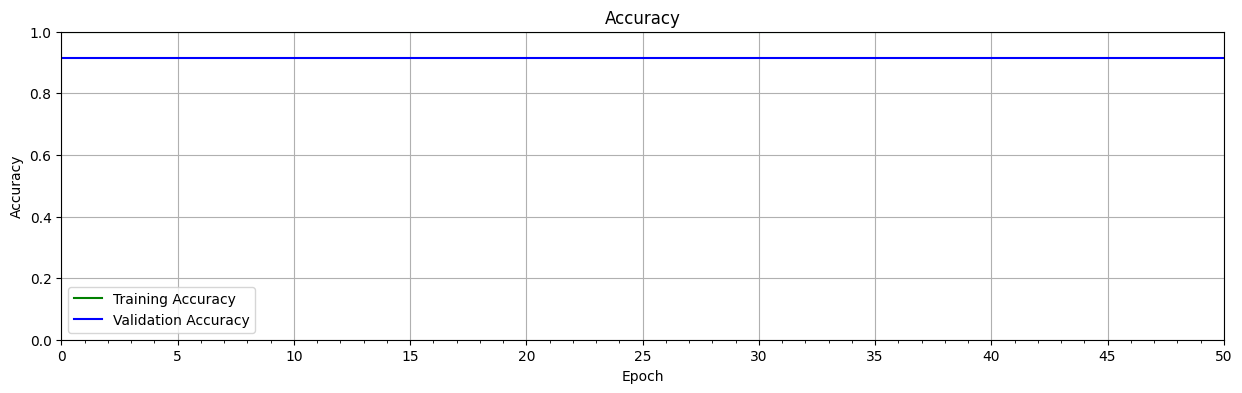

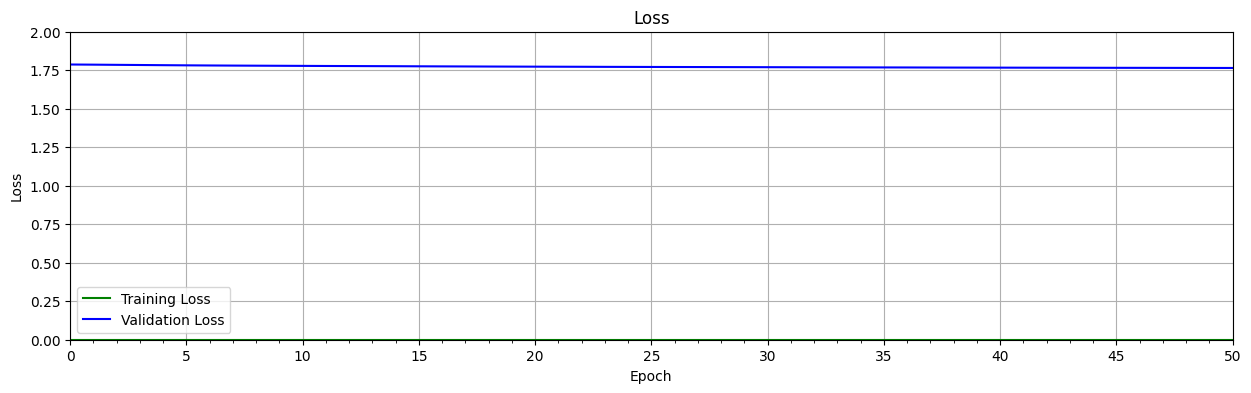

In [81]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

max_loss = 2.0

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

In [84]:
vgg16_model.save('cnn_tl_model.h5')
#keras.saving.save_model(model)
vgg16_model.save('cnn_tl_model.keras')

## 5 Model Evaluation

In [ ]:
# Load saved model.
# Final evaluation accuracy on the validation set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

7/7 [==============================] - 1s 80ms/step - loss: 0.2975 - accuracy: 0.9750
Model evaluation accuracy: 97.500


## 6 Conclusion

In this notebook, we demonstrated how to use **transfer learning** to achieve a higher validation accuracy on the **ecommerce images** dataset when compared to training the model from scratch.

In [85]:
def evaluate_model(dataset, model):

    num_matches = 0
    plt.figure(figsize=(17, 12))
    num_rows = 5
    num_cols = 6
    class_names = dataset.class_names

    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):
        predictions = model.predict(data_batch)

        for idx in range(num_rows*num_cols):
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.axis("off")
            plt.imshow(data_batch[idx].numpy().astype("uint8"))

            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())

            title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
            title_obj = plt.title(title, fontdict={'fontsize':11})

            if pred_idx == truth_idx:
                num_matches += 1
                plt.setp(title_obj, color='g')
            else:
                plt.setp(title_obj, color='r')

            acc = num_matches/(idx+1)
        print("Prediction accuracy: ", int(100*acc)/100)
    
    plt.savefig('images/eval.png')

    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Prediction accuracy:  0.86


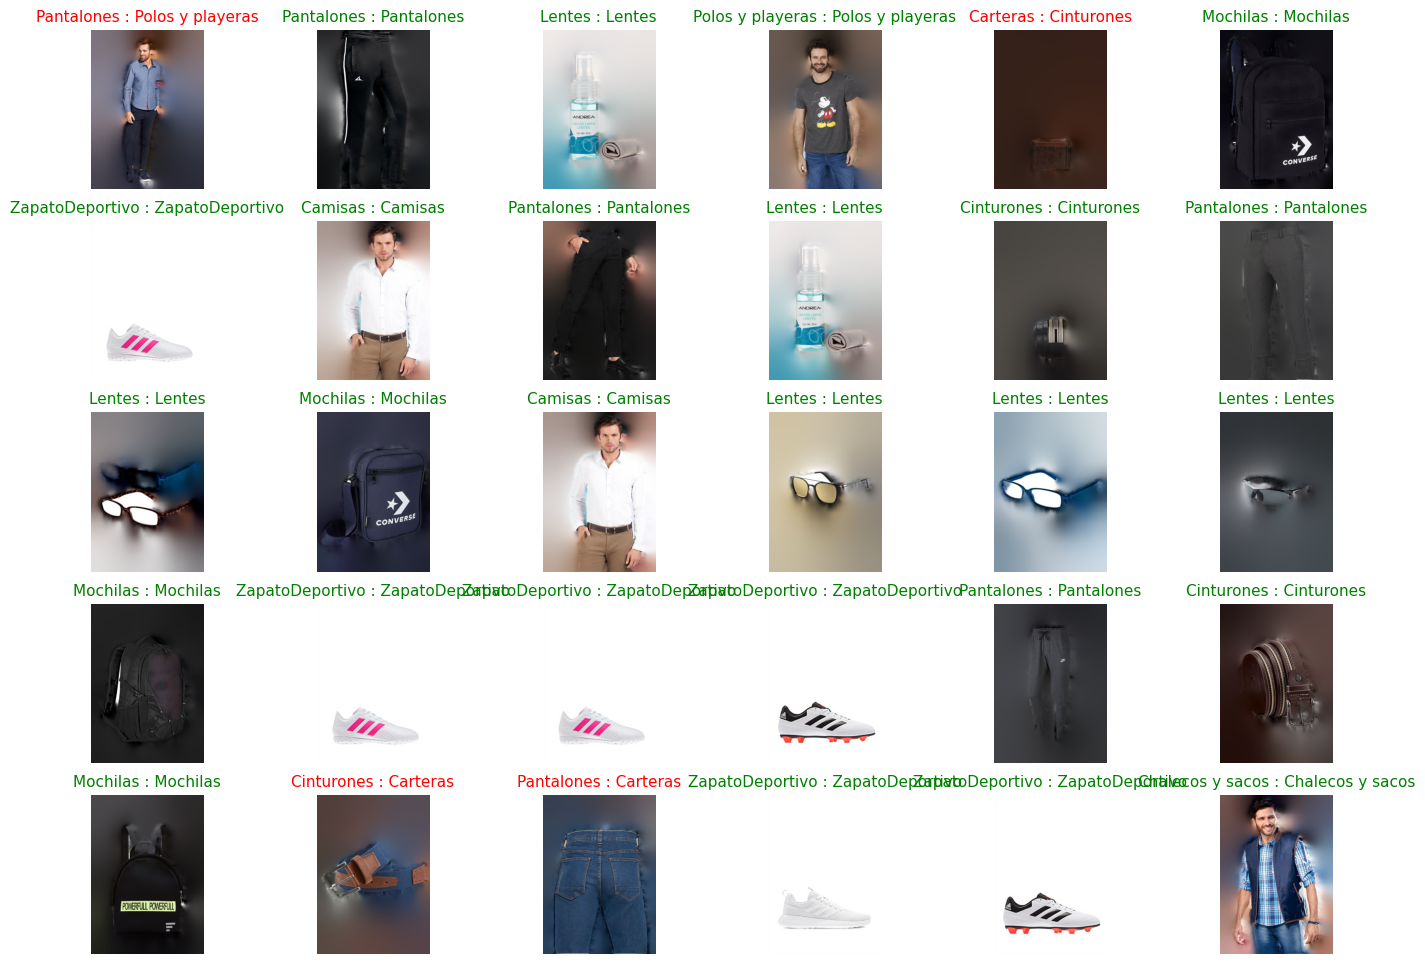

In [90]:
evaluate_model(valid_dataset, vgg16_model)